In [1]:
!pip install --upgrade tensorflow

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

#Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Categories

In [3]:
categories = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']

##dataset path

In [4]:
data_dir = "/content/drive/My Drive/donateacry_corpus_cleaned_and_updated_data"

##Function to extract Mel Spectrogram features

In [5]:
def extract_features(file_path, max_pad_length=128):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Padding or truncating
        if mel_spec_db.shape[1] < max_pad_length:
            pad_width = max_pad_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_pad_length]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

##Loading Dataset

In [6]:
data = []
labels = []

for category in categories:
  folder_path = os.path.join(data_dir, category)
  for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    features = extract_features(file_path)
    if features is not None:
      data.append(features)
      labels.append(category)

<ipython-input-7-b11cfdc5ad93>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")


<function matplotlib.pyplot.show(close=None, block=None)>

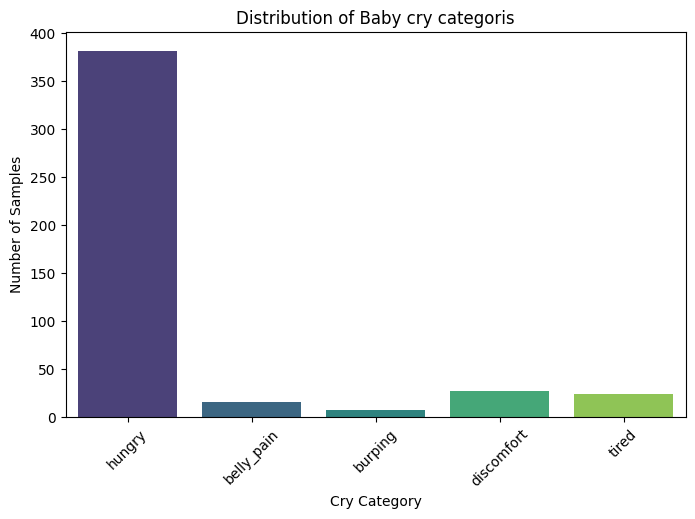

In [7]:
label_counts = Counter(labels)

plt.figure(figsize=(8,5))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")
plt.xlabel("Cry Category")
plt.ylabel("Number of Samples")
plt.title("Distribution of Baby cry categoris")
plt.xticks(rotation=45)
plt.show

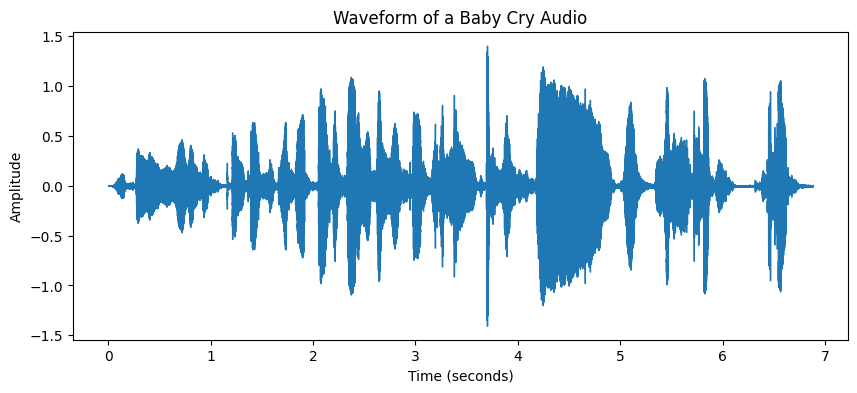

In [8]:
sample_file = os.path.join(data_dir, 'hungry', os.listdir(os.path.join(data_dir, 'hungry'))[0])
audio, sr = librosa.load(sample_file, sr=22050)

plt.figure(figsize=(10,4))
librosa.display.waveshow(audio, sr=sr)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of a Baby Cry Audio")
plt.show()

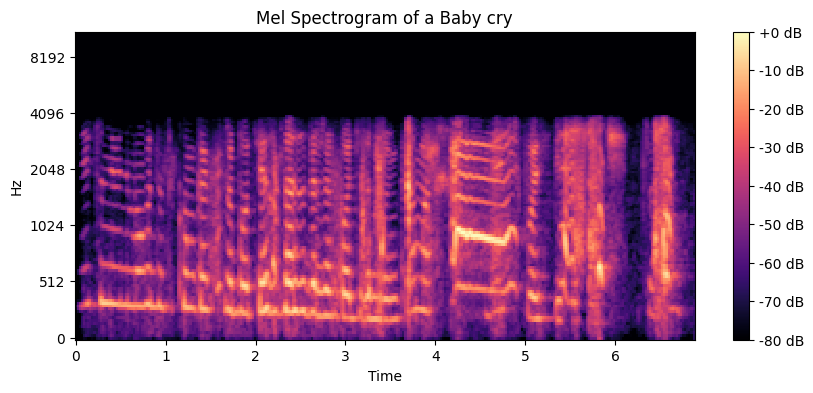

In [9]:
mel_spec = librosa.feature.melspectrogram(y = audio, sr=sr)
mel_spec_db = librosa.power_to_db(mel_spec, ref = np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram of a Baby cry")
plt.show()

##Convert to NumPy arrays

In [10]:
data = np.array(data)
data = np.expand_dims(data, axis =-1)

##Encode Labels

In [11]:
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_encoded = tf.keras.utils.to_categorical(labels_encoded, num_classes=len(categories))

##Data Shape

In [12]:
print(f"Shape of data: {data.shape}")
print(f"Shape od labels: {labels_encoded.shape}")

Shape of data: (457, 128, 128, 1)
Shape od labels: (457, 5)


#Spliting Data

In [13]:
x_train, x_test, y_train, y_test = train_test_split(data, labels_encoded, test_size= 0.2, random_state=42)

##Define CNN Model

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(categories), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compile model

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train model

In [17]:
history = model.fit(x_train, y_train, epochs=9, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 869ms/step - accuracy: 0.5602 - loss: 83.3569 - val_accuracy: 0.8043 - val_loss: 3.6248
Epoch 2/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 819ms/step - accuracy: 0.8343 - loss: 1.5653 - val_accuracy: 0.8043 - val_loss: 0.8401
Epoch 3/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 715ms/step - accuracy: 0.8577 - loss: 0.7804 - val_accuracy: 0.8043 - val_loss: 0.8017
Epoch 4/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 881ms/step - accuracy: 0.8024 - loss: 0.7886 - val_accuracy: 0.8043 - val_loss: 0.9551
Epoch 5/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 796ms/step - accuracy: 0.8179 - loss: 0.8488 - val_accuracy: 0.8043 - val_loss: 0.8131
Epoch 6/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 782ms/step - accuracy: 0.8468 - loss: 0.6714 - val_accuracy: 0.8043 - val_loss: 0.8791
Epoch 7/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 887ms/step - accuracy: 0.8470 - loss: 0.6454 - val_accuracy: 0.8043 - val_loss: 0.8646
Epoch 8/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 831ms/step - accuracy: 0.8405 - loss: 0.6532 - val_accuracy: 0.

## Evaluate model

In [19]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7897 - loss: 2.7084
Test Accuracy: 0.78


## Save model

In [20]:
model.save("baby_cry_model.h5")
